Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation, Flatten, Dense, concatenate, GlobalAveragePooling2D, Identity
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import tifffile
import os
import cv2
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

2025-10-03 10:28:09.062590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759487289.309583      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759487289.379004      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
save_dir = '/kaggle/working/'
data_dir = '/kaggle/input/agricultural-hotspot-fapar-rasters-conflict-info/processed_data'

### DATA PREPARATION

In [3]:
df = pd.read_csv(f"{data_dir}/processed_df.csv")
display(df.head())
display(df.info())

,iso3,year,month,tavg,tmin,tmax,pres,tsun,prcp,conflict_events,conflict_3mo_avg,conflict_6mo_sum,conflict_prev,conflict_spike,conflict_rel,hs_code,hs_name,processed_image_path,iso3_encoded
0,AGO,2021,2,26.6,24.1,30.7,1010.2,13295.02584,753.0,2.0,2.000000,2.0,0.0,1,0.36796,1,Hotspot,/content/drive/MyDrive/Colab Notebooks/Unilag ...,0
1,AGO,2021,3,26.6,24.0,30.3,1009.7,13295.02584,575.4,6.0,7.666667,25.0,3.0,0,1.10388,1,Hotspot,/content/drive/MyDrive/Colab Notebooks/Unilag ...,0
2,AGO,2021,4,27.1,24.4,31.4,1009.7,13295.02584,755.4,5.0,7.333333,45.0,8.0,0,0.91990,1,Hotspot,/content/drive/MyDrive/Colab Notebooks/Unilag ...,0
3,AGO,2021,5,26.9,24.2,30.7,1011.2,13295.02584,201.6,1.0,4.666667,36.0,6.0,0,0.18398,1,Hotspot,/content/drive/MyDrive/Colab Notebooks/Unilag ...,0
4,AGO,2021,6,25.1,22.9,28.4,1012.7,13295.02584,69.0,1.0,2.666667,22.0,3.0,0,0.18398,1,Hotspot,/content/drive/MyDrive/Colab Notebooks/Unilag ...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4188 entries, 0 to 4187
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   iso3                  4188 non-null   object 
 1   year                  4188 non-null   int64  
 2   month                 4188 non-null   int64  
 3   tavg                  4188 non-null   float64
 4   tmin                  4188 non-null   float64
 5   tmax                  4188 non-null   float64
 6   pres                  4188 non-null   float64
 7   tsun                  4188 non-null   float64
 8   prcp                  4188 non-null   float64
 9   conflict_events       4188 non-null   float64
 10  conflict_3mo_avg      4188 non-null   float64
 11  conflict_6mo_sum      4188 non-null   float64
 12  conflict_prev         4188 non-null   float64
 13  conflict_spike        4188 non-null   int64  
 14  conflict_rel          4188 non-null   float64
 15  hs_code              

None

In [4]:
# Replace the file path prefix
df['processed_image_path'] = df['processed_image_path'].str.replace('/content/drive/MyDrive/Colab Notebooks/Unilag project/fapar_patches_processed/', f'{data_dir}/fapar_patches_processed/')

# Drop rows where 'hs_name' is "Not assessed"
df = df[df['hs_name'] != "Not assessed"].copy()

# Set 'hs_code' to 1 for rows where 'hs_name' is "Major hotspot"
df.loc[df['hs_name'] == "Major hotspot", 'hs_code'] = 1

display(df.head())
display(df.info())

,iso3,year,month,tavg,tmin,tmax,pres,tsun,prcp,conflict_events,conflict_3mo_avg,conflict_6mo_sum,conflict_prev,conflict_spike,conflict_rel,hs_code,hs_name,processed_image_path,iso3_encoded
0,AGO,2021,2,26.6,24.1,30.7,1010.2,13295.02584,753.0,2.0,2.000000,2.0,0.0,1,0.36796,1,Hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,0
1,AGO,2021,3,26.6,24.0,30.3,1009.7,13295.02584,575.4,6.0,7.666667,25.0,3.0,0,1.10388,1,Hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,0
2,AGO,2021,4,27.1,24.4,31.4,1009.7,13295.02584,755.4,5.0,7.333333,45.0,8.0,0,0.91990,1,Hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,0
3,AGO,2021,5,26.9,24.2,30.7,1011.2,13295.02584,201.6,1.0,4.666667,36.0,6.0,0,0.18398,1,Hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,0
4,AGO,2021,6,25.1,22.9,28.4,1012.7,13295.02584,69.0,1.0,2.666667,22.0,3.0,0,0.18398,1,Hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,0


<class 'pandas.core.frame.DataFrame'>
Index: 4110 entries, 0 to 4187
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   iso3                  4110 non-null   object 
 1   year                  4110 non-null   int64  
 2   month                 4110 non-null   int64  
 3   tavg                  4110 non-null   float64
 4   tmin                  4110 non-null   float64
 5   tmax                  4110 non-null   float64
 6   pres                  4110 non-null   float64
 7   tsun                  4110 non-null   float64
 8   prcp                  4110 non-null   float64
 9   conflict_events       4110 non-null   float64
 10  conflict_3mo_avg      4110 non-null   float64
 11  conflict_6mo_sum      4110 non-null   float64
 12  conflict_prev         4110 non-null   float64
 13  conflict_spike        4110 non-null   int64  
 14  conflict_rel          4110 non-null   float64
 15  hs_code               4110

None

In [5]:
def create_time_series_splits(df, n_steps, val_test_split_ratio):
    """
    Creates time series sequences and splits data into training, validation, and test sets
    per country.

    Args:
        df (pd.DataFrame): The input DataFrame with time series data and 'iso3' column.
        n_steps (int): The number of time steps in each input sequence (X).
        val_test_split_ratio (float): The combined proportion of data for validation and testing.

    Returns:
        tuple: A tuple containing X_train, y_train, X_val, y_val, X_test, y_test.
               Returns (None, None, None, None, None, None) if processing fails or no data.
    """
    all_X_train, all_y_train = [], []
    all_X_val, all_y_val = [], []
    all_X_test, all_y_test = [], []

    # Group by country
    grouped_data = df.groupby('iso3')

    for iso3, country_df in grouped_data:
        # Sort data chronologically
        country_df = country_df.sort_values(by=['year', 'month'])
        numeric_cols = country_df.select_dtypes(include=np.number).columns.tolist()
        country_data = country_df[numeric_cols].values

        # Check if there's enough data to create at least one sequence for train, val, and test
        required_length = n_steps + 1  # n_steps for X, 1 for y
        if len(country_data) < required_length + int(len(country_data) * val_test_split_ratio):
            print(f"Skipping country {iso3}: Insufficient data ({len(country_data)} rows) to create sequences and splits with n_steps={n_steps} and val_test_split_ratio={val_test_split_ratio}.")
            continue

        # Create time series sequences
        X, y = [], []
        for i in range(len(country_data) - n_steps):
            # Create input sequence (X)
            seq_x = country_data[i:(i + n_steps)]
            X.append(seq_x)
            seq_y = country_data[i + n_steps]
            y.append(seq_y)

        X = np.array(X)
        y = np.array(y)

        # Determine split points
        num_sequences = len(X)
        if num_sequences == 0:
             print(f"Skipping country {iso3}: No sequences could be created with n_steps={n_steps}.")
             continue

        val_test_size = int(num_sequences * val_test_split_ratio)
        test_size = val_test_size // 2
        val_size = val_test_size - test_size
        train_size = num_sequences - val_test_size

        if train_size <= 0:
             print(f"Skipping country {iso3}: Not enough sequences ({num_sequences}) for training with val_test_split_ratio={val_test_split_ratio}.")
             continue


        # Split data chronologically
        X_train = X[:train_size]
        y_train = y[:train_size]
        X_val = X[train_size:(train_size + val_size)]
        y_val = y[train_size:(train_size + val_size)]
        X_test = X[(train_size + val_size):]
        y_test = y[(train_size + val_size):]

        all_X_train.append(X_train)
        all_y_train.append(y_train)
        all_X_val.append(X_val)
        all_y_val.append(y_val)
        all_X_test.append(X_test)
        all_y_test.append(y_test)

    # Concatenate data from all countries
    if not all_X_train: # Check if any training data was generated
        print("No training data generated for any country.")
        return None, None, None, None, None, None

    X_train_combined = np.concatenate(all_X_train, axis=0)
    y_train_combined = np.concatenate(all_y_train, axis=0)
    X_val_combined = np.concatenate(all_X_val, axis=0) if all_X_val else np.array([])
    y_val_combined = np.concatenate(all_y_val, axis=0) if all_y_val else np.array([])
    X_test_combined = np.concatenate(all_X_test, axis=0) if all_X_test else np.array([])
    y_test_combined = np.concatenate(all_y_test, axis=0) if all_y_test else np.array([])


    return X_train_combined, y_train_combined, X_val_combined, y_val_combined, X_test_combined, y_test_combined


In [6]:
def split_dataframe_chronologically_by_country(df, val_test_split_ratio):
    """
    Splits a DataFrame into training, validation, and test sets chronologically
    per country.

    Args:
        df (pd.DataFrame): The input DataFrame with time series data and 'iso3' column.
        val_test_split_ratio (float): The combined proportion of data for validation and testing.

    Returns:
        tuple: A tuple containing train_df, val_df, test_df.
               Returns (pd.DataFrame(), pd.DataFrame(), pd.DataFrame()) if no data.
    """
    all_train_dfs, all_val_dfs, all_test_dfs = [], [], []

    # Group by country
    grouped_data = df.groupby('iso3')

    for iso3, country_df in grouped_data:
        # Sort data chronologically
        country_df = country_df.sort_values(by=['year', 'month']).reset_index(drop=True)

        num_rows = len(country_df)

        # Determine split points
        val_test_size = int(num_rows * val_test_split_ratio)
        test_size = val_test_size // 2
        val_size = val_test_size - test_size
        train_size = num_rows - val_test_size

        if train_size <= 0:
             print(f"Skipping country {iso3}: Not enough data ({num_rows} rows) for training after split with val_test_split_ratio={val_test_split_ratio}.")
             continue

        # Split data chronologically
        train_df_country = country_df.iloc[:train_size].copy()
        val_df_country = country_df.iloc[train_size:(train_size + val_size)].copy()
        test_df_country = country_df.iloc[(train_size + val_size):].copy()

        all_train_dfs.append(train_df_country)
        all_val_dfs.append(val_df_country)
        all_test_dfs.append(test_df_country)

    # Concatenate dataframes from all countries
    train_df_combined = pd.concat(all_train_dfs, ignore_index=True) if all_train_dfs else pd.DataFrame()
    val_df_combined = pd.concat(all_val_dfs, ignore_index=True) if all_val_dfs else pd.DataFrame()
    test_df_combined = pd.concat(all_test_dfs, ignore_index=True) if all_test_dfs else pd.DataFrame()


    return train_df_combined, val_df_combined, test_df_combined

### Splitting DataFrames and Creating Datasets and DataLoaders

In [7]:
# Define split ratio and parameters for Dataset and DataLoader
val_test_split_ratio = 0.3
n_steps_for_dataloader = 6
forecast_horizon = 3
output_dir = f"{data_dir}/fapar_patches_processed"
batch_size = 32
num_workers = 2
target_col = 'hs_code' # Assuming the target column is 'hs_code'

# Split the DataFrame chronologically by country
train_df, val_df, test_df = split_dataframe_chronologically_by_country(df, val_test_split_ratio)

In [8]:
train_df

,iso3,year,month,tavg,tmin,tmax,pres,tsun,prcp,conflict_events,conflict_3mo_avg,conflict_6mo_sum,conflict_prev,conflict_spike,conflict_rel,hs_code,hs_name,processed_image_path,iso3_encoded
0,AGO,2021,2,26.6,24.1,30.7,1010.2,13295.02584,753.0,2.0,2.000000,2.0,0.0,1,0.367960,1,Hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,0
1,AGO,2021,3,26.6,24.0,30.3,1009.7,13295.02584,575.4,6.0,7.666667,25.0,3.0,0,1.103880,1,Hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,0
2,AGO,2021,4,27.1,24.4,31.4,1009.7,13295.02584,755.4,5.0,7.333333,45.0,8.0,0,0.919900,1,Hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,0
3,AGO,2021,5,26.9,24.2,30.7,1011.2,13295.02584,201.6,1.0,4.666667,36.0,6.0,0,0.183980,1,Hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,0
4,AGO,2021,6,25.1,22.9,28.4,1012.7,13295.02584,69.0,1.0,2.666667,22.0,3.0,0,0.183980,1,Hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2908,ZWE,2023,8,22.9,17.9,28.9,1018.5,13295.02584,0.0,27.0,22.333333,115.0,38.0,0,3.911468,0,No hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,61
2909,ZWE,2023,9,27.3,21.6,33.8,1012.5,13295.02584,0.0,18.0,16.000000,115.0,29.0,0,2.607645,0,No hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,61
2910,ZWE,2023,10,30.5,25.3,36.4,1010.0,13295.02584,4.5,9.0,10.333333,79.0,19.0,0,1.303823,0,No hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,61
2911,ZWE,2023,11,31.0,26.4,36.4,1009.9,13295.02584,16.2,8.0,6.666667,51.0,10.0,0,1.158954,0,No hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,61


In [9]:
val_df

,iso3,year,month,tavg,tmin,tmax,pres,tsun,prcp,conflict_events,conflict_3mo_avg,conflict_6mo_sum,conflict_prev,conflict_spike,conflict_rel,hs_code,hs_name,processed_image_path,iso3_encoded
0,AGO,2024,2,28.1,25.1,31.9,1010.7,13295.02584,699.0,1.0,3.666667,17.0,3.0,0,0.183980,0,No hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,0
1,AGO,2024,3,28.6,25.7,32.2,1009.7,13295.02584,840.6,3.0,2.000000,17.0,2.0,0,0.551940,0,No hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,0
2,AGO,2024,4,28.2,25.4,32.1,1009.3,13295.02584,498.0,5.0,4.000000,18.0,3.0,0,0.919900,0,No hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,0
3,AGO,2024,5,27.9,25.7,31.4,1010.5,13295.02584,150.6,5.0,5.333333,28.0,7.0,0,0.919900,0,No hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,0
4,AGO,2024,6,24.8,22.3,28.2,1013.4,13295.02584,17.7,8.0,5.333333,32.0,8.0,0,1.471840,0,No hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,ZWE,2024,3,29.1,25.4,33.2,1012.1,13295.02584,19.2,4.0,4.666667,28.0,6.0,0,0.579477,1,Major hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,61
606,ZWE,2024,4,26.0,22.7,29.9,1014.2,13295.02584,124.5,3.0,4.666667,28.0,5.0,0,0.434608,1,Major hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,61
607,ZWE,2024,5,24.1,19.7,29.1,1017.4,13295.02584,0.0,2.0,1.666667,19.0,3.0,0,0.289738,1,Major hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,61
608,ZWE,2024,6,21.8,17.3,26.9,1019.7,13295.02584,7.5,3.0,2.666667,13.0,2.0,0,0.434608,1,Major hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,61


In [10]:
test_df

,iso3,year,month,tavg,tmin,tmax,pres,tsun,prcp,conflict_events,conflict_3mo_avg,conflict_6mo_sum,conflict_prev,conflict_spike,conflict_rel,hs_code,hs_name,processed_image_path,iso3_encoded
0,AGO,2024,11,26.5,24.1,29.4,1011.2,13295.02584,837.3,0.0,0.666667,7.0,0.0,0,0.000000,0,No hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,0
1,AGO,2025,1,26.7,24.3,29.7,1010.8,13295.02584,471.0,2.0,2.000000,8.0,0.0,1,0.367960,0,No hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,0
2,AGO,2025,2,26.5,24.2,29.6,1009.8,13295.02584,608.1,3.0,2.000000,12.0,3.0,0,0.551940,0,No hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,0
3,AGO,2025,4,26.8,24.4,32.7,1010.1,13295.02584,386.4,2.0,2.333333,13.0,3.0,0,0.367960,0,No hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,0
4,AGO,2025,5,25.9,23.9,29.6,1012.0,13295.02584,513.9,3.0,3.333333,17.0,3.0,0,0.551940,0,No hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,ZWE,2025,1,26.2,23.6,29.1,1009.2,13295.02584,990.0,2.0,2.000000,14.0,2.0,0,0.289738,1,Hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,61
583,ZWE,2025,2,26.9,24.2,30.0,1009.3,13295.02584,805.2,0.0,1.333333,10.0,2.0,0,0.000000,0,No hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,61
584,ZWE,2025,5,22.8,19.4,26.8,1018.7,13295.02584,12.3,2.0,0.666667,6.0,0.0,1,0.289738,0,No hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,61
585,ZWE,2025,6,20.6,16.6,25.5,1019.9,13295.02584,0.0,2.0,2.333333,9.0,2.0,0,0.289738,0,No hotspot,/kaggle/input/agricultural-hotspot-fapar-raste...,61


In [11]:
print(f"Train DataFrame shape: {train_df.shape}")
print(f"Validation DataFrame shape: {val_df.shape}")
print(f"Test DataFrame shape: {test_df.shape}")

Train DataFrame shape: (2913, 19)
Validation DataFrame shape: (610, 19)
Test DataFrame shape: (587, 19)


## NOW, OFF TO *DATALOADER*
Create a custom dataset and dataloader to load processed TIFF files and corresponding numerical data from a pandas DataFrame for time series prediction, ensuring the data is in a suitable format for a machine learning model.

First. we create a Python class that inherits from a data loading library's Dataset class (`torch.utils.data.Dataset`).


In [12]:
class ConflictDataset(Dataset):
    """Custom Dataset for loading processed FAPAR images and numerical data for multi-step forecasting."""

    def __init__(self, dataframe, img_dir, n_steps, forecast_horizon, target_col='hs_code', target_size=(256, 256)):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing numerical features and image paths.
            img_dir (str): Directory with processed image files.
            n_steps (int): Number of time steps in the input sequence (X).
            forecast_horizon (int): The number of future time steps to forecast.
            target_col (str): The name of the target column in the DataFrame. Defaults to 'hs_code'.
            target_size (tuple): The target spatial size (height, width) for image resizing. Defaults to (256, 256).
        """
        self.dataframe = dataframe.copy()
        self.img_dir = img_dir
        self.n_steps = n_steps
        self.forecast_horizon = forecast_horizon
        self.target_col = target_col
        self.target_size = target_size # (height, width)

        # Pre-process the DataFrame to create sequences and store image paths, multi-step numerical targets, and classification targets
        self.sequences = []
        self.image_paths = []
        self.numerical_targets = [] # Targets for numerical feature prediction
        self.classification_targets = [] # Targets for classification
        self.indices = [] # Store original DataFrame index for potential debugging or joining later
        self.target_image_paths = []


        # Ensure DataFrame is sorted by country, year, and month
        self.dataframe = self.dataframe.sort_values(by=['iso3', 'year', 'month']).reset_index(drop=True)

        # Group by country
        grouped_data = self.dataframe.groupby('iso3')

        for iso3, country_df in grouped_data:
            # Determine numerical feature columns excluding 'year' and 'target_col' for the input sequence
            numerical_feature_cols_input = [col for col in country_df.select_dtypes(include=np.number).columns.tolist() if col not in ['year', self.target_col]]

            # Determine numerical feature columns for the numerical target sequence
            # This should match the features the forecast model is predicting.
            # Based on ModelTrainer, this is numerical_feature_cols, which excludes 'year' and 'target_col'
            numerical_feature_cols_target = [col for col in country_df.select_dtypes(include=np.number).columns.tolist() if col not in ['year', self.target_col]]


            country_features_input = country_df[numerical_feature_cols_input].values
            country_numerical_targets_data = country_df[numerical_feature_cols_target].values # Use the filtered list for targets
            country_classification_targets_data = country_df[self.target_col].values
            country_image_paths = country_df['processed_image_path'].values
            country_indices = country_df.index.values # Original indices in the sorted df


            # Create time series sequences with multi-step targets
            # We need enough data for the input sequence (n_steps) PLUS the forecast horizon
            for i in range(len(country_df) - self.n_steps - self.forecast_horizon + 1):
                # Numerical sequence (X)
                seq_x = country_features_input[i:(i + self.n_steps)]
                self.sequences.append(seq_x)

                # Image paths for the sequence (X) - we need n_steps images
                seq_img_paths = country_image_paths[i:(i + self.n_steps)]
                self.image_paths.append(seq_img_paths)

                # Multi-step numerical targets (y_num)
                # Starting from the step immediately following the input sequence
                seq_y_num = country_numerical_targets_data[(i + self.n_steps):(i + self.n_steps + self.forecast_horizon)]
                self.numerical_targets.append(seq_y_num)

                self.target_image_paths.append(country_image_paths[(i + self.n_steps):(i + self.n_steps + self.forecast_horizon)])

                # Multi-step classification targets (y_cls)
                seq_y_cls = country_classification_targets_data[(i + self.n_steps):(i + self.n_steps + self.forecast_horizon)]
                self.classification_targets.append(seq_y_cls)


                # Store the index of the first target element in the original sorted df
                self.indices.append(country_indices[i + self.n_steps])


        self.sequences = np.array(self.sequences)
        # image_paths are already a list of numpy arrays/lists
        self.numerical_targets = np.array(self.numerical_targets)
        self.classification_targets = np.array(self.classification_targets)
        self.indices = np.array(self.indices)


    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.sequences)

    def __getitem__(self, idx):
        """Retrieves a sample (sequence of numerical features, sequence of images, multi-step numerical target, multi-step classification target) at the given index."""
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the numerical sequence and targets
        numerical_sequence = self.sequences[idx]
        numerical_target = self.numerical_targets[idx]
        classification_target = self.classification_targets[idx]
        original_index = self.indices[idx]


        # Load and process the corresponding image sequence
        processed_image_sequence = []
        for img_filename in self.image_paths[idx]:
            img_path = img_filename # img_filename already contains the full path after previous processing steps
            try:
                # Load image using tifffile
                img = tifffile.imread(img_path)
                img = np.nan_to_num(img, nan=0) # Handle potential NaN values
                img = np.mean(img, axis = -1)

                # Normalize image to [0, 1]
                if img.max() > img.min():
                    img = (img - img.min()) / (img.max() - img.min())
                else:
                    img = np.zeros_like(img) # Avoid division by zero if all values are the same

                # Resize image directly to the target size
                # original_height, original_width = img.shape[:2]
                target_height, target_width = self.target_size
                # Resize using OpenCV (handles grayscale and color images correctly)
                # Target size is (width, height) for cv2.resize
                processed_img = cv2.resize(img, (target_width, target_height), interpolation=cv2.INTER_AREA)


                processed_image_sequence.append(processed_img)

            except FileNotFoundError:
                print(f"Warning: Image file not found at {img_path}. Returning zero array for this image.")
                # Return a zero array with the target size and channel count if image is not found
                # Assuming 3 channels for consistency if original images are color, otherwise 1
                channels = processed_image_sequence[0].shape[-1] if processed_image_sequence else (img.shape[-1] if img.ndim == 3 else 1)
                processed_image_sequence.append(np.zeros(self.target_size + (channels,), dtype=np.float32))

            except Exception as e:
                print(f"Error loading or processing image {img_path}: {e}. Returning zero array for this image.")
                # Return a zero array with the target size and channel count on other errors
                channels = processed_image_sequence[0].shape[-1] if processed_image_sequence else (img.shape[-1] if img.ndim == 3 else 1)
                processed_image_sequence.append(np.zeros(self.target_size + (channels,), dtype=np.float32))



        # Stack processed images along the time step dimension (axis=0)
        # Resulting shape will be (n_steps, height, width, channels)
        image_sequence_stacked = np.stack(processed_image_sequence, axis=0)

        # Load and process the corresponding image sequence
        target_processed_image_sequence = []
        for img_filename in self.target_image_paths[idx]:
            img_path = img_filename # img_filename already contains the full path after previous processing steps
            try:
                # Load image using tifffile
                img = tifffile.imread(img_path)
                img = np.nan_to_num(img, nan=0) # Handle potential NaN values
                img = np.mean(img, axis = -1)

                # Normalize image to [0, 1]
                if img.max() > img.min():
                    img = (img - img.min()) / (img.max() - img.min())
                else:
                    img = np.zeros_like(img) # Avoid division by zero if all values are the same


                # Resize image directly to the target size
                # original_height, original_width = img.shape[:2]
                target_height, target_width = self.target_size

                # Resize using OpenCV (handles grayscale and color images correctly)
                # Target size is (width, height) for cv2.resize
                processed_img = cv2.resize(img, (target_width, target_height), interpolation=cv2.INTER_AREA)

                target_processed_image_sequence.append(processed_img)

            except FileNotFoundError:
                print(f"Warning: Image file not found at {img_path}. Returning zero array for this image.")
                # Return a zero array with the target size and channel count if image is not found
                # Assuming 3 channels for consistency if original images are color, otherwise 1
                channels = processed_image_sequence[0].shape[-1] if processed_image_sequence else (img.shape[-1] if img.ndim == 3 else 1)
                processed_image_sequence.append(np.zeros(self.target_size + (channels,), dtype=np.float32))

            except Exception as e:
                print(f"Error loading or processing image {img_path}: {e}. Returning zero array for this image.")
                # Return a zero array with the target size and channel count on other errors
                channels = processed_image_sequence[0].shape[-1] if processed_image_sequence else (img.shape[-1] if img.ndim == 3 else 1)
                target_processed_image_sequence.append(np.zeros(self.target_size + (channels,), dtype=np.float32))



        # Stack processed images along the time step dimension (axis=0)
        # Resulting shape will be (n_steps, height, width, channels)
        target_processed_image_sequence_stacked = np.stack(target_processed_image_sequence, axis=0)


        # Convert numpy arrays to PyTorch tensors
        numerical_sequence_tensor = np.array(numerical_sequence, dtype=np.float32)
        image_sequence_tensor = np.array(image_sequence_stacked, dtype=np.float32)
        target_image_sequence_tensor = np.array(target_processed_image_sequence_stacked, dtype=np.float32)
        numerical_target_tensor = np.array(numerical_target, dtype=np.float32)
        classification_target_tensor = np.array(classification_target, dtype=np.uint8) # Classification targets are usually LongTensors

        return numerical_sequence_tensor, image_sequence_tensor, numerical_target_tensor, target_image_sequence_tensor, classification_target_tensor, original_index

In [13]:
train_dataset = ConflictDataset(train_df, output_dir,
                                3, 2, target_col='hs_code', target_size=(64,64))
# Convert PyTorch data to NumPy arrays (or other compatible format)
num_seqs, im_seqs, num_targets, im_targets, target_cls = [], [], [], [], []
for num_seq, im_seq, num_target, im_target, target_ls, _ in train_dataset:
    num_seqs.append(num_seq)
    im_seqs.append(im_seq)
    num_targets.append(num_target)
    im_targets.append(im_target)
    target_cls.append(target_ls)

train_images = np.array(im_seqs)
train_features = np.array(num_seqs)
train_target_images = np.array(im_targets)
train_target_features = np.array(num_targets)
train_classes = np.array(target_cls)

del num_seqs, im_seqs, num_targets, im_targets, target_cls
gc.collect()

2442

In [14]:
val_dataset = ConflictDataset(val_df, output_dir,
                                3, 2, target_col='hs_code', target_size=(64,64))
# Convert PyTorch data to NumPy arrays (or other compatible format)
num_seqs, im_seqs, num_targets, im_targets, target_cls = [], [], [], [], []
for num_seq, im_seq, num_target, im_target, target_ls, _ in val_dataset:
    num_seqs.append(num_seq)
    im_seqs.append(im_seq)
    num_targets.append(num_target)
    im_targets.append(im_target)
    target_cls.append(target_ls)

val_images = np.array(im_seqs)
val_features = np.array(num_seqs)
val_target_images = np.array(im_targets)
val_target_features = np.array(num_targets)
val_classes = np.array(target_cls)

del num_seqs, im_seqs, num_targets, im_targets, target_cls
gc.collect()

844

In [15]:
test_dataset = ConflictDataset(test_df, output_dir,
                                3, 2, target_col='hs_code', target_size=(64,64))
# Convert PyTorch data to NumPy arrays (or other compatible format)
num_seqs, im_seqs, num_targets, im_targets, target_cls = [], [], [], [], []
for num_seq, im_seq, num_target, im_target, target_ls, _ in test_dataset:
    num_seqs.append(num_seq)
    im_seqs.append(im_seq)
    num_targets.append(num_target)
    im_targets.append(im_target)
    target_cls.append(target_ls)

test_images = np.array(im_seqs)
test_features = np.array(num_seqs)
test_target_images = np.array(im_targets)
test_target_features = np.array(num_targets)
test_classes = np.array(target_cls)

del num_seqs, im_seqs, num_targets, im_targets, target_cls
gc.collect()

1218

In [16]:
train_images.shape, test_images.shape, val_images.shape

((2665, 3, 64, 64), (348, 3, 64, 64), (370, 3, 64, 64))

In [17]:
train_features.shape, test_features.shape, val_features.shape

((2665, 3, 14), (348, 3, 14), (370, 3, 14))

In [18]:
train_target_images.shape, test_target_images.shape, val_target_images.shape

((2665, 2, 64, 64), (348, 2, 64, 64), (370, 2, 64, 64))

In [19]:
train_images = train_images.transpose((0,2,3,1))
val_images = val_images.transpose((0,2,3,1))
test_images = test_images.transpose((0,2,3,1))
print(train_images.shape)
print(val_images.shape)
print(test_images.shape)

(2665, 64, 64, 3)
(370, 64, 64, 3)
(348, 64, 64, 3)


In [20]:
train_target_images = train_target_images.transpose((0,2,3,1))
val_target_images = val_target_images.transpose((0,2,3,1))
test_target_images = test_target_images.transpose((0,2,3,1))
print(train_target_images.shape)
print(val_target_images.shape)
print(test_target_images.shape)

(2665, 64, 64, 2)
(370, 64, 64, 2)
(348, 64, 64, 2)


In [21]:
train_target_images[...,0].shape

(2665, 64, 64)

In [22]:
train_features.shape

(2665, 3, 14)

In [23]:
train_features.shape

(2665, 3, 14)

In [24]:
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features.reshape((-1,14))).reshape((-1,3,14))
train_target_features = scaler.transform(train_target_features.reshape((-1,14))).reshape((-1,2,14))

val_features = scaler.transform(val_features.reshape((-1,14))).reshape((-1,3,14))
val_target_features = scaler.transform(val_target_features.reshape((-1,14))).reshape((-1,2,14))

test_features = scaler.transform(test_features.reshape((-1,14))).reshape((-1,3,14))
test_target_features = scaler.transform(test_target_features.reshape((-1,14))).reshape((-1,2,14))

### Define the u-net architecture


In [25]:
def build_unet_resnet_fixed_input(input_shape, num_output_channels):
    """Builds a U-Net model with a ResNet50 encoder, handling custom input channels.

    Args:
        input_shape (tuple): The shape of the input image (height, width, channels).
        num_output_channels (int): The number of channels in the output image.

    Returns:
        tf.keras.Model: The built U-Net model.
    """
    inputs = Input(shape=input_shape)

    resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs, pooling=None)

    skip_connections = [
        resnet.get_layer('conv2_block3_out').output,  # e.g., after first residual block group
        resnet.get_layer('conv3_block4_out').output,  # e.g., after second residual block group
        resnet.get_layer('conv4_block6_out').output,  # e.g., after third residual block group
        resnet.get_layer('conv5_block3_out').output   # e.g., bottleneck/last encoder output
    ]

    # Bottleneck (The output of the deepest encoder layer)
    bottleneck = skip_connections[-1]
    encoder_output = bottleneck # Rename for clarity

    # Decoder
    # Start with the bottleneck and progressively upsample and concatenate with skip connections
    x = encoder_output

    # Reverse the skip connections for the decoder path
    skip_connections = skip_connections[::-1]

    # Decoder path
    # Adjust filters and layers as needed for your specific task
    filters = [256, 128, 64, 32, 16] # Example filter sizes for decoder layers

    for i, skip_connection in enumerate(skip_connections):
        # Upsampling
        x = UpSampling2D((2, 2))(x)

        # Concatenate with the corresponding skip connection
        # Adjust the index for skip_connections as they are reversed
        if i < len(skip_connections) - 1: # Don't concatenate in the first decoder step (bottleneck)
             x = concatenate([x, skip_connections[i+1]])


        # Convolutional layers in the decoder block
        x = Conv2D(filters[i], (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(filters[i], (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    x = UpSampling2D((2, 2))(x)
    x = concatenate([x, inputs])
    # Convolutional layers in the decoder block
    x = Conv2D(filters[-1], (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters[-1], (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # Final Output Layer
    outputs = Conv2D(num_output_channels, (1, 1), activation='relu')(x)


    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    return model

input_shape = (64, 64, 3)
num_output_channels = 2

# Build the model
unet_model = build_unet_resnet_fixed_input(input_shape, num_output_channels)

I0000 00:00:1759487370.347888      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [26]:
# Compile the model
unet_model.compile(optimizer=Adam(learning_rate=0.001),
                         loss='mean_squared_error',  # Assuming image regression task
                         metrics=['mean_absolute_error'])

# Display the model summary
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 32,585,650 (124.30 MB)

 Trainable params: 32,530,546 (124.09 MB)

 Non-trainable params: 55,104 (215.25 KB)

In [27]:
batch_size = 16
initial_lr = 0.0
target_lr = 1e-1
warmup_steps = len(train_images)//(batch_size*10)
total_train_steps = len(train_images)//batch_size
decay_steps = total_train_steps - warmup_steps
alpha_min_lr = 1e-5

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    alpha=alpha_min_lr,
    warmup_target=target_lr,
    warmup_steps=warmup_steps
)

optimizer = Adam(learning_rate=lr_schedule)

In [28]:
# Compile the model
unet_model.compile(optimizer=optimizer,
                         loss='mean_squared_error',  # Assuming image regression task
                         metrics=['mean_absolute_error'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(f'{save_dir}/resUnet.keras', verbose=1, save_best_only=True)
]

with tf.device('/gpu:0'):
    unet_results = unet_model.fit(train_images, train_target_images, batch_size=batch_size, epochs=100, callbacks=callbacks,\
                    validation_data=(val_images, val_target_images))

Epoch 1/100


I0000 00:00:1759487377.433995      19 cuda_dnn.cc:529] Loaded cuDNN version 90300


167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0612 - mean_absolute_error: 0.1770
Epoch 1: val_loss improved from inf to 0.02330, saving model to /kaggle/working//resUnet.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - loss: 0.0610 - mean_absolute_error: 0.1767 - val_loss: 0.0233 - val_mean_absolute_error: 0.1235
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0200 - mean_absolute_error: 0.1079
Epoch 2: val_loss did not improve from 0.02330
167/167 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - loss: 0.0200 - mean_absolute_error: 0.1079 - val_loss: 0.0236 - val_mean_absolute_error: 0.1251
Epoch 3/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0194 - mean_absolute_error: 0.1067
Epoch 3: val_loss improved from 0.02330 to 0.02319, saving model to /kaggle/working//resUnet.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - loss: 0.0194 - mean_absolute_error: 0.1067 - val_loss: 0.0232 - val_mean_absolute_error: 0.1238
Epoch 4/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 

In [29]:
unet_model.evaluate(test_images, test_target_images)

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 326ms/step - loss: 0.0194 - mean_absolute_error: 0.1129


[0.020451797172427177, 0.11531638354063034]

In [30]:
preds_rasters = unet_model.predict(test_images)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step


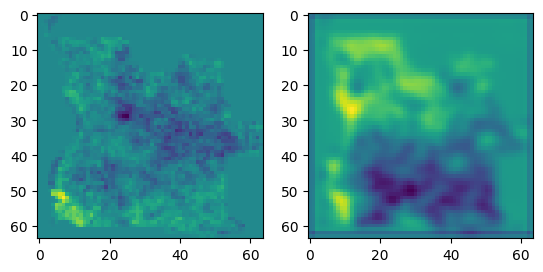

In [31]:
plt.subplot(1,2,1)
plt.imshow(test_target_images[0,...,0])

plt.subplot(1,2,2)
plt.imshow(preds_rasters[0,...,0])

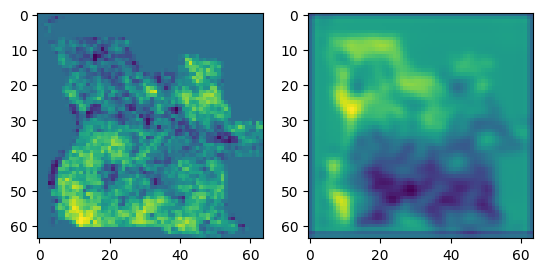

In [32]:
plt.subplot(1,2,1)
plt.imshow(test_target_images[0,...,1])

plt.subplot(1,2,2)
plt.imshow(preds_rasters[0,...,1])

In [33]:
train_images_preds = unet_model.predict(train_images)
val_images_preds = unet_model.predict(val_images)

84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 288ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 302ms/step


### LSTM MODEL

In [34]:
def build_lstm_model(input_shape, output_steps, num_features):
    """
    Builds an LSTM model for time series forecasting.

    Args:
        input_shape (tuple): The shape of the input sequence (n_steps, num_features).
        output_steps (int): The number of future time steps to forecast.
        num_features (int): The number of features in the input and output.

    Returns:
        tf.keras.Model: The built LSTM model.
    """
    inputs = tf.keras.layers.Input(shape=input_shape)

    # LSTM layers
    lstm_out = tf.keras.layers.LSTM(512, return_sequences=False)(inputs)
    # Flatten the input sequence
    flattened_input = tf.keras.layers.Flatten()(inputs)

    # Concatenate the flattened input with the LSTM output
    concatenated_output = tf.keras.layers.Concatenate()([lstm_out, flattened_input])

    # Dense layer
    dense_out = tf.keras.layers.Dense(output_steps * num_features)(concatenated_output) # Output layer to predict all features for all future steps

    # Reshape to (output_steps, num_features)
    outputs = tf.keras.layers.Reshape((output_steps, num_features))(dense_out)


    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# Define the parameters based on your data
n_steps_input = 3
forecast_steps_output = 2
num_features = train_features.shape[-1] # Get the number of features from your training data

# Build the LSTM model
lstm_model = build_lstm_model(input_shape=(n_steps_input, num_features),
                              output_steps=forecast_steps_output,
                              num_features=num_features)

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='mse', # Mean Squared Error for regression task
                   metrics=['mae']) # Mean Absolute Error as a metric

# Display the model summary
lstm_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 3, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 512)       │  1,079,296 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 42)        │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 554)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 28)        │     15,540 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 2, 14)     │          0 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,094,836 (4.18 MB)

 Trainable params: 1,094,836 (4.18 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
callbacks = [
    ModelCheckpoint(f'{save_dir}/lstm_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Train the LSTM model
with tf.device('/gpu:0'):
    lstm_results = lstm_model.fit(train_features, train_target_features,
                                  epochs=100,
                                  batch_size=batch_size,
                                  validation_data=(val_features, val_target_features),
                                  callbacks=callbacks)

Epoch 1/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.6254 - mae: 0.4624
Epoch 1: val_loss improved from inf to 0.49192, saving model to /kaggle/working//lstm_model.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.6246 - mae: 0.4621 - val_loss: 0.4919 - val_mae: 0.3491
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.3843 - mae: 0.3345
Epoch 2: val_loss improved from 0.49192 to 0.44516, saving model to /kaggle/working//lstm_model.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.3842 - mae: 0.3344 - val_loss: 0.4452 - val_mae: 0.3161
Epoch 3/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.3408 - mae: 0.3022
Epoch 3: val_loss improved from 0.44516 to 0.42929, saving model to /kaggle/working//lstm_model.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.3407 - mae: 0.3022 - val_loss: 0.4293 - val_mae: 0.3058
Epoch 4/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3185 - mae: 0.2917
Epoch 4: val_loss improved from 0.42929 to

In [36]:
lstm_model.evaluate(test_features, test_target_features)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3839 - mae: 0.3084


[0.3877711296081543, 0.2979928255081177]

### MULTILABEL CLASSIFIER

In [37]:
def build_multilabel_classifier(image_input_shape, numerical_input_shape, num_classes):
    """
    Builds a multilabel classification model that takes image and numerical inputs.

    Args:
        image_input_shape (tuple): The shape of the input image (height, width, channels).
        numerical_input_shape (tuple): The shape of the numerical input (time_steps, features).
        num_classes (int): The number of output classes for multilabel classification.

    Returns:
        tf.keras.Model: The built multilabel classification model.
    """
    # Image Input Branch
    image_inputs = Input(shape=image_input_shape, name='image_input')

    # Simple CNN to extract features from the image
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(image_inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x) # Reduce spatial dimensions and get features

    # Numerical Input Branch
    numerical_inputs = Input(shape=numerical_input_shape, name='numerical_input')
    numerical_flattened = Flatten()(numerical_inputs) # Flatten the numerical input

    # Concatenate the features from both branches
    combined_features = concatenate([x, numerical_flattened])

    # Dense layers for classification
    y = Dense(128, activation='relu')(combined_features)
    y = Dense(64, activation='relu')(y)

    # Output layer for multilabel classification (sigmoid activation for each class)
    outputs = Dense(num_classes, activation='sigmoid', name='classification_output')(y)

    # Create the model
    model = Model(inputs=[image_inputs, numerical_inputs], outputs=outputs)

    return model

# Define input shapes and number of classes
image_shape = (64, 64, 2) # Based on your processed target image shape
numerical_shape = (2, 14) # Based on your processed target numerical features shape
num_classes = 2 # Assuming 2 classes for multilabel prediction

# Build the classification model
multilabel_cls_model = build_multilabel_classifier(image_shape, numerical_shape, num_classes)

# Compile the model
multilabel_cls_model.compile(optimizer=Adam(learning_rate=0.001),
                             loss='binary_crossentropy', # Binary crossentropy for multilabel classification
                             metrics=['accuracy'])

# Display the model summary
multilabel_cls_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 64, 64, 2) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 64,    │        608 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 64, 64,    │     18,496 │ conv2d_11[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 2, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_12[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 28)        │          0 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 92)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     11,904 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_out… │ (None, 2)         │        130 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 39,394 (153.88 KB)

 Trainable params: 39,394 (153.88 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Data for training
train_cls_inputs = [train_target_images, train_target_features]
train_cls_targets = train_classes

# Data for validation
val_cls_inputs = [val_target_images, val_target_features]
val_cls_targets = val_classes

# Data for testing
test_cls_inputs = [test_target_images, test_target_features]
test_cls_targets = test_classes

In [39]:
# Define callbacks (optional, but recommended)
callbacks = [
    ModelCheckpoint(f'{save_dir}/multilabel_classifier.keras', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Train the multilabel classification model
with tf.device('/gpu:0'):
    multilabel_cls_results = multilabel_cls_model.fit(train_cls_inputs, train_cls_targets,
                                                      epochs=100,
                                                      batch_size=batch_size, # Use the previously defined batch_size
                                                      validation_data=(val_cls_inputs, val_cls_targets),
                                                      callbacks=callbacks)

Epoch 1/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.4554 - loss: 0.3529
Epoch 1: val_loss improved from inf to 0.42721, saving model to /kaggle/working//multilabel_classifier.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.4555 - loss: 0.3527 - val_accuracy: 0.3946 - val_loss: 0.4272
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.4112 - loss: 0.2804
Epoch 2: val_loss improved from 0.42721 to 0.41034, saving model to /kaggle/working//multilabel_classifier.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.4117 - loss: 0.2804 - val_accuracy: 0.3730 - val_loss: 0.4103
Epoch 3/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.3950 - loss: 0.2644
Epoch 3: val_loss improved from 0.41034 to 0.38962, saving model to /kaggle/working//multilabel_classifier.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.3955 - loss: 0.2643 - val_accuracy: 0.5162 - val_loss: 0.3896
Epoch 4/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0

In [40]:
multilabel_cls_model.evaluate(test_cls_inputs, test_cls_targets)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4141 - loss: 0.2961


[0.3572574853897095, 0.4712643623352051]

In [41]:
multilabel_cls_preds = multilabel_cls_model.predict(test_cls_inputs)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [42]:
print(classification_report(test_cls_targets.flatten(), np.uint8(multilabel_cls_preds>0.5).flatten()))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       605
           1       0.62      0.23      0.34        91

    accuracy                           0.88       696
   macro avg       0.76      0.60      0.64       696
weighted avg       0.86      0.88      0.86       696



### COMBINED MODELS

In [43]:
# Define inputs for the combined model
image_input_combined = Input(shape=(64, 64, 3), name='unet_input')
numerical_input_combined = Input(shape=(3, 14), name='lstm_input')

# First Stage: U-Net and LSTM
# Assuming unet_model and lstm_model are already defined and loaded
unet_output = unet_model(image_input_combined)
lstm_output = lstm_model(numerical_input_combined)

# Second Stage: Multilabel Classifier
# The multilabel classifier takes image and numerical inputs.
# We will use the outputs from the U-Net and LSTM as these inputs.
# The multilabel_cls_model expects inputs in the order of [image_input, numerical_input]
multilabel_classifier_output = multilabel_cls_model([unet_output, lstm_output])

# Define the combined model
# The combined model has two inputs and three outputs:
# 1. U-Net output (predicted image)
# 2. LSTM output (predicted numerical features)
# 3. Multilabel classifier output (classification prediction)
unet_output_named = Identity(name='image_prediction')(unet_output)
lstm_output_named = Identity(name='feature_prediction')(lstm_output)
multilabel_output_named = Identity(name='classification_output')(multilabel_classifier_output)

combined_model = Model(
    inputs=[image_input_combined, numerical_input_combined],
    outputs=[
        unet_output_named,
        lstm_output_named,
        multilabel_output_named
    ]
)

# Display the model summary
combined_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ unet_input          │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_input          │ (None, 3, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 64, 64, 2) │ 32,585,650 │ unet_input[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 2, 14)     │  1,094,836 │ lstm_input[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, 2)         │     39,394 │ functional[0][0], │
│ (Functional)        │                   │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_prediction    │ (None, 64, 64, 2) │          0 │ functional[0][0]  │
│ (Identity)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_prediction  │ (None, 2, 14)     │          0 │ functional_1[0][… │
│ (Identity)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_out… │ (None, 2)         │          0 │ functional_2[0][… │
│ (Identity)          │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,719,880 (128.63 MB)

 Trainable params: 33,664,776 (128.42 MB)

 Non-trainable params: 55,104 (215.25 KB)

In [44]:
# Compile the combined model using the STABLE NAMES
combined_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss={
        'image_prediction': 'mse',           # Stable name
        'feature_prediction': 'mse',         # Stable name
        'classification_output': 'binary_crossentropy' # Stable name
    },
    metrics={
        'image_prediction': ['mae'],
        'feature_prediction': ['mae'],
        'classification_output': ['accuracy']
    }
)

In [45]:
# Prepare data for the combined model
# Inputs:
# - Image sequence (for U-Net): train_images, val_images, test_images
# - Numerical sequence (for LSTM): train_features, val_features, test_features

# Targets:
# - Target image sequence (for U-Net output): train_target_images, val_target_images, test_target_images
# - Target numerical features (for LSTM output): train_target_features, val_target_features, test_target_features
# - Classification targets (for multilabel classification output): train_classes, val_classes, test_classes

# Data for training
train_combined_inputs = [train_images, train_features]
train_combined_targets = {
    'image_prediction': train_target_images,
    'feature_prediction': train_target_features,
    'classification_output': train_classes
}

# Data for validation
val_combined_inputs = [val_images, val_features]
val_combined_targets = {
    'image_prediction': val_target_images,
    'feature_prediction': val_target_features,
    'classification_output': val_classes
}

# Data for testing
test_combined_inputs = [test_images, test_features]
test_combined_targets = {
    'image_prediction': test_target_images,
    'feature_prediction': test_target_features,
    'classification_output': test_classes
}

In [46]:
# Define callbacks (optional, but recommended)
callbacks = [
    ModelCheckpoint(f'{save_dir}/combined_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Train the combined model
# Use the combined inputs and targets dictionary
with tf.device('/gpu:0'):
    combined_results = combined_model.fit(train_combined_inputs, train_combined_targets,
                                          epochs=100,
                                          batch_size=batch_size, # Use the previously defined batch_size
                                          validation_data=(val_combined_inputs, val_combined_targets),
                                          callbacks=callbacks)

Epoch 1/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - classification_output_accuracy: 0.5232 - classification_output_loss: 0.2595 - feature_prediction_loss: 0.1870 - feature_prediction_mae: 0.2113 - image_prediction_loss: 0.0194 - image_prediction_mae: 0.1067 - loss: 0.4659
Epoch 1: val_loss improved from inf to 0.76036, saving model to /kaggle/working//combined_model.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - classification_output_accuracy: 0.5232 - classification_output_loss: 0.2594 - feature_prediction_loss: 0.1869 - feature_prediction_mae: 0.2113 - image_prediction_loss: 0.0194 - image_prediction_mae: 0.1067 - loss: 0.4658 - val_classification_output_accuracy: 0.5730 - val_classification_output_loss: 0.3631 - val_feature_prediction_loss: 0.3739 - val_feature_prediction_mae: 0.2676 - val_image_prediction_loss: 0.0233 - val_image_prediction_mae: 0.1234 - val_loss: 0.7604
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - classification_output_accuracy: 0.5402 - classificati

In [47]:
combined_model.evaluate(test_combined_inputs, test_combined_targets)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step - classification_output_accuracy: 0.4975 - classification_output_loss: 0.2755 - feature_prediction_loss: 0.3812 - feature_prediction_mae: 0.3059 - image_prediction_loss: 0.0191 - image_prediction_mae: 0.1119 - loss: 0.6758


[0.7455328702926636,
 0.020123999565839767,
 0.3845616579055786,
 0.3408471643924713,
 0.517241358757019,
 0.29539990425109863,
 0.11432057619094849]

In [48]:
combined_model_prediction = combined_model.predict(test_combined_inputs)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step


In [49]:
classes = combined_model_prediction[-1]
classes.shape

(348, 2)

In [50]:
month1 = classes[...,0]
month2 = classes[...,1]

In [51]:
thresholds = np.arange(0,1,0.1).tolist()
for thresh in thresholds:
  print("***"*30, f" MONTH1 - {thresh} ", "***"*30)
  print(classification_report(test_classes[...,0], np.uint8(month1>thresh)))

******************************************************************************************  MONTH1 - 0.0  ******************************************************************************************
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       302
           1       0.13      1.00      0.23        46

    accuracy                           0.13       348
   macro avg       0.07      0.50      0.12       348
weighted avg       0.02      0.13      0.03       348

******************************************************************************************  MONTH1 - 0.1  ******************************************************************************************
              precision    recall  f1-score   support

           0       0.93      0.70      0.79       302
           1       0.24      0.63      0.35        46

    accuracy                           0.69       348
   macro avg       0.58      0.66      0.57       348
weighte

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

In [52]:
thresholds = np.arange(0,1,0.1).tolist()
for thresh in thresholds:
  print("***"*30, f" MONTH2 - {thresh} ", "***"*30)
  print(classification_report(test_classes[...,1], np.uint8(month2>thresh)))

******************************************************************************************  MONTH2 - 0.0  ******************************************************************************************
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       303
           1       0.13      1.00      0.23        45

    accuracy                           0.13       348
   macro avg       0.06      0.50      0.11       348
weighted avg       0.02      0.13      0.03       348

******************************************************************************************  MONTH2 - 0.1  ******************************************************************************************
              precision    recall  f1-score   support

           0       0.93      0.69      0.79       303
           1       0.23      0.64      0.34        45

    accuracy                           0.68       348
   macro avg       0.58      0.67      0.57       348
weighte

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

In [53]:
thresholds = np.arange(0,1,0.1).tolist()
for thresh in thresholds:
  print("***"*30, f" MONTH1&2 - {thresh} ", "***"*30)
  print(classification_report(test_classes.flatten(), np.uint8(classes.flatten()>thresh)))

******************************************************************************************  MONTH1&2 - 0.0  ******************************************************************************************
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       605
           1       0.13      1.00      0.23        91

    accuracy                           0.13       696
   macro avg       0.07      0.50      0.12       696
weighted avg       0.02      0.13      0.03       696

******************************************************************************************  MONTH1&2 - 0.1  ******************************************************************************************
              precision    recall  f1-score   support

           0       0.93      0.69      0.79       605
           1       0.24      0.64      0.35        91

    accuracy                           0.68       696
   macro avg       0.58      0.66      0.57       696
wei

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif